# Forecasting Demand for Products in Corporation Favorita Stores Using Machine Learning Models

### Introduction
Corporation Favorita, a large Ecuadorian-based grocery retailer, aims to maintain optimal inventory levels at its numerous stores while maximizing revenue. With diverse factors influencing consumer behavior and market conditions, understanding historical sales trends and identifying contributing elements is crucial. We propose developing a comprehensive suite of machine learning models tailored to predicting product demand across various locations, thereby enabling informed decision-making regarding inventory management and resource allocation.

### Company Description and Situation
Corporation Favorita operates a vast network of grocery stores throughout Ecuador, offering a wide range of products catering to diverse customer needs. Amid fluctuating economic conditions, volatile oil prices, seasonality, regional preferences, and competitive pressures, managing inventory effectively becomes increasingly challenging. By leveraging data analytics and machine learning, Corporation Favorita seeks to enhance supply chain efficiency, minimize waste, and improve overall financial performance.

### Hypotheses

    Increases in oil prices negatively impact sales due to reduced disposable income.
    
    Promotions drive higher sales compared to non-promoted periods.


### Business Objective
Our primary goal is to construct accurate forecasting models capable of estimating weekly product demand per store location considering exogenous factors such as promotional activities, oil prices, holidays, and local events. Ultimately, our solution should empower Corporation Favorita to:

    Ensure adequate inventory levels
    Optimize pricing strategies
    Anticipate fluctuations in demand
    Align staff scheduling according to anticipated foot traffic


### Analytical Questions
To address the challenges faced by Corporation Favorita and achieve the objectives outlined above, consider the following analytical questions:

   1. Is the train dataset complete (contains all required dates)?
   2. Which weekdays exhibit consistently high sales volumes over time?
   3. How does sales volume vary across cities, states, types, and clusters?
   4.  Are there discernible trends in monthly sales figures spanning multiple years?
   5.  Did the earthquake significantly impact sales, either positively or negatively?
   6.  Does the implementation of promotions yield consistent increases in sales?
   7.  Can oil prices, holidays, and local events explain variations in sales volume?
   8.  Which product families experience increased sales during promotion campaigns?
   9.  Why does the mean absolute error exceed root mean square logarithmic error and root mean squared error?
   10. Is there evidence suggesting that wage payments in the public sector affect store sales?

By systematically addressing these questions, we aim to deliver actionable insights supporting improved operational efficiency and strategic planning within Corporation Favorita's extensive retail ecosystem.

### Get Data

In [76]:
# Data Handling
import pyodbc
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from scipy import stats
from dotenv import dotenv_values
import random

# Statistical Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import ttest_ind
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from pmdarima import auto_arima


# Machine Learning Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline

import calplot
# Joblib for saving components
import joblib

import os

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

# Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Preprocessing and Utilities
import pandas_datareader as pdr
from itertools import product

# Formatting and Documentation
import jupyter
import ipykernel
import nbconvert

# Database connections
from dotenv import load_dotenv, dotenv_values
# Other Packages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load environment variables from .env file into a dictionary
#environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
#database = environment_variables.get("database")
#server = environment_variables.get("server")
#username = environment_variables.get("user")
#password = environment_variables.get("password")


#connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"



In [3]:
train_df = train = pd.read_csv("Datasets/train.csv")
oil = pd.read_csv("Datasets/oil.csv", parse_dates=["date"], infer_datetime_format=True)
stores = pd.read_csv("Datasets/stores.csv")
holidays_events = pd.read_csv("Datasets/holidays_events.csv", parse_dates=["date"])
transactions = pd.read_csv("Datasets/transactions.csv", parse_dates=["date"])
test_df = test = pd.read_csv("Datasets/test.csv") # Note: update this filename when Test.csv is available

In [4]:
# Getting information on all datasets
datasets = ['train_df', 'oil', 'stores', 'holidays_events', 'transactions', 'test_df']

# Iterate over each dataset and inspect its properties
for name in datasets:
    df = globals()[name]
    
    if isinstance(df, pd.DataFrame):
        print("\n" + "-" * 50)
        print(f"\nDataset Name: {name}\n")
        print("-" * 50)
        print("Shape:", df.shape)
        print("Datatypes:\n", df.dtypes)
        missing_values = df.isna().sum().sort_values(ascending=False)
        print("\nNumber of Missing Values per Column:\n", missing_values)


--------------------------------------------------

Dataset Name: train_df

--------------------------------------------------
Shape: (3000888, 6)
Datatypes:
 id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

Number of Missing Values per Column:
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

--------------------------------------------------

Dataset Name: oil

--------------------------------------------------
Shape: (1218, 2)
Datatypes:
 date          datetime64[ns]
dcoilwtico           float64
dtype: object

Number of Missing Values per Column:
 dcoilwtico    43
date           0
dtype: int64

--------------------------------------------------

Dataset Name: stores

--------------------------------------------------
Shape: (54, 5)
Datatypes:
 store_nbr     int64
city         object
state        object
type       

### ***Key Insights***
The train dataset contains 3,000,888 rows and 6 columns while the test dataset contains 28,512 rows and 5 columns.

The train dataset is significantly larger than the test dataset in terms of the number of rows. This is expected, as the train dataset is usually larger to provide sufficient data for model training.
The Holiday Events dataset contains 350 rows and 6 columns. This dataset provides information about various holidays and events.

The Oil dataset consists of 1,218 rows and 2 columns. This dataset includes information about the daily price of oil. There are 43 NULL values. NULL values constitute only 3.5% of total rows.

The Stores dataset contains 54 rows and 5 columns. This dataset provides details about different stores, such as their locations, types, and clusters.

The Transactions dataset contains 83,488 rows and 3 columns. This dataset contains information about the number of transactions made at each store on specific dates.

In [5]:
# Converting the 'date' column in the datasets to datetime format
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
transactions['date'] = pd.to_datetime(transactions['date'])

In [6]:
# Checking for missing values in the datasets
def missing_values(dataset_name, dataset):
    print(f"Missing values in {dataset_name} dataset:")
    print(dataset.isnull().sum())
    print('='*58)

In [7]:
# Display missing values for all datasets
missing_values('Train', train_df)
missing_values('Test', test_df)
missing_values('Holiday Events', holidays_events)
missing_values('Oil', oil)
missing_values('Stores', stores)
missing_values('Transactions', transactions)

Missing values in Train dataset:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
Missing values in Test dataset:
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
Missing values in Holiday Events dataset:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
Missing values in Oil dataset:
date           0
dcoilwtico    43
dtype: int64
Missing values in Stores dataset:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
Missing values in Transactions dataset:
date            0
store_nbr       0
transactions    0
dtype: int64


In [8]:
# Set 'date' as the index for the train_df
train_df.set_index('date', inplace=True)
train_df.sort_index(ascending=True)

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0
2013-01-01,1,1,BABY CARE,0.000,0
2013-01-01,2,1,BEAUTY,0.000,0
2013-01-01,3,1,BEVERAGES,0.000,0
2013-01-01,4,1,BOOKS,0.000,0
...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0
2017-08-15,3000884,9,PREPARED FOODS,154.553,1
2017-08-15,3000885,9,PRODUCE,2419.729,148


In [9]:
# Display the unique store numbers and date range
unique_store_numbers = train_df.store_nbr.unique()
start_day = train_df.index.min()
end_day = train_df.index.max()
print(f'The start day is {start_day} and the end date is {end_day}')

The start day is 2013-01-01 00:00:00 and the end date is 2017-08-15 00:00:00


In [10]:
# Create a DataFrame with unique values of other columns
unique_store_numbers = train_df['store_nbr'].unique()
unique_category = train_df['family'].unique()

In [11]:
# Create a DataFrame with missing dates and unique values of other columns
date_range = pd.date_range(start=start_day, end=end_day)
missing_dates = date_range.difference(train_df.index)

missing_df = pd.DataFrame(list(product(unique_store_numbers, missing_dates, unique_category)),
                          columns=['store_nbr', 'date', 'family'])

missing_df.set_index('date', inplace=True)

In [12]:
date_range = pd.date_range(start=start_day, end=end_day,)
date_range

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

In [13]:
# Merge missing_df with train_df
merged_df = pd.concat([train_df, missing_df], axis=0)
merged_df.sort_index(ascending=True)

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0.0,1,AUTOMOTIVE,0.000,0.0
2013-01-01,1194.0,42,CELEBRATION,0.000,0.0
2013-01-01,1193.0,42,BREAD/BAKERY,0.000,0.0
2013-01-01,1192.0,42,BOOKS,0.000,0.0
2013-01-01,1191.0,42,BEVERAGES,0.000,0.0
...,...,...,...,...,...
2017-08-15,2999695.0,25,POULTRY,172.517,0.0
2017-08-15,2999694.0,25,PLAYERS AND ELECTRONICS,3.000,0.0
2017-08-15,2999693.0,25,PET SUPPLIES,3.000,0.0


In [14]:
# Fill missing values
merged_df['sales'] = merged_df['sales'].fillna(0)
merged_df['onpromotion'] = merged_df['onpromotion'].fillna(0)
merged_df['id'] = merged_df['id'].interpolate(method='linear')

In [15]:
merged_df.isnull().sum()

id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

### Univariate Analysis

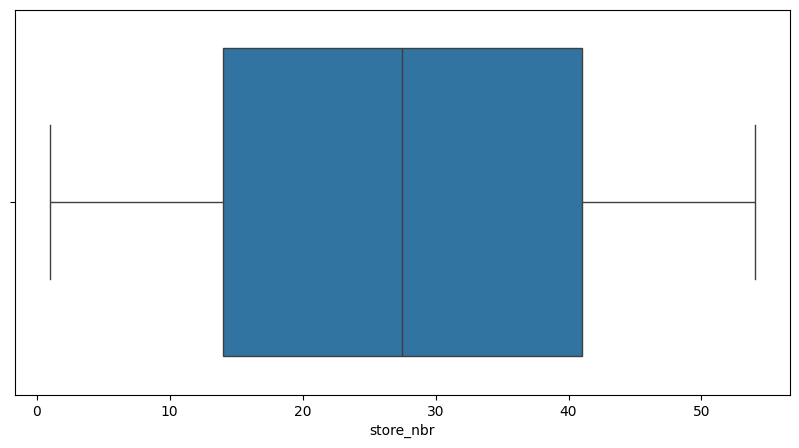

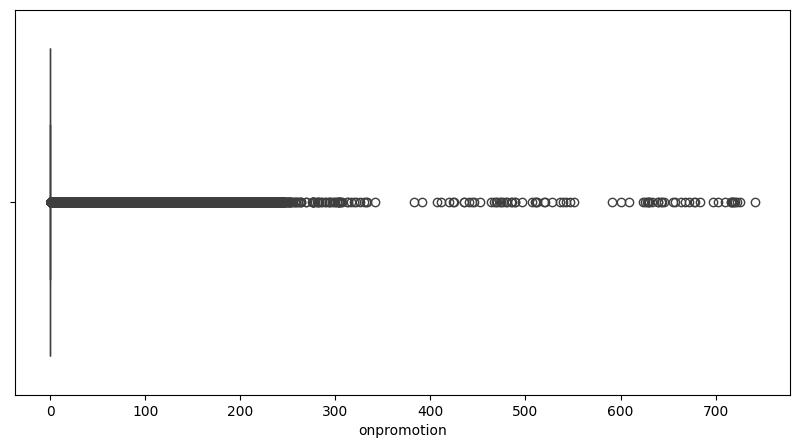

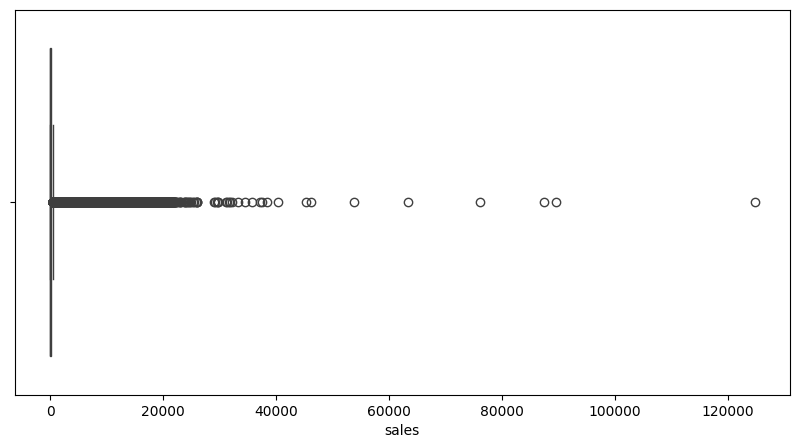

id             -0.000058
store_nbr       0.000000
sales           7.366962
onpromotion    11.179506
dtype: float64


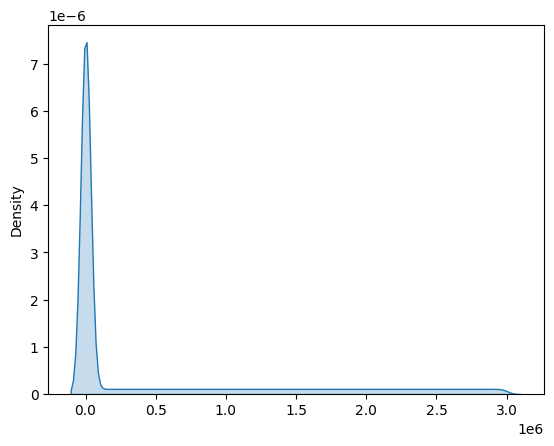

In [16]:
# Univariate Analysis
plt.figure(figsize=(10, 5))
sns.boxplot(merged_df['store_nbr'], orient='h')
plt.figure(figsize=(10, 5))
sns.boxplot(merged_df['onpromotion'], orient='h')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(merged_df['sales'], orient='h')
plt.show()

sns.kdeplot(merged_df.drop(['family', 'onpromotion'], axis=1).values.ravel(), fill=True)

# Check the skewness of numeric columns
numeric_columns = merged_df.select_dtypes(include=['number'])
skewness = numeric_columns.skew()
print(skewness)

##### The data is positively skewed

### Bivariate Analysis

In [17]:
def create_new_features(df):
    df['month_name'] = df.index.month_name()
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day'] = df.index.dayofweek
    return df

merged_df = create_new_features(merged_df)

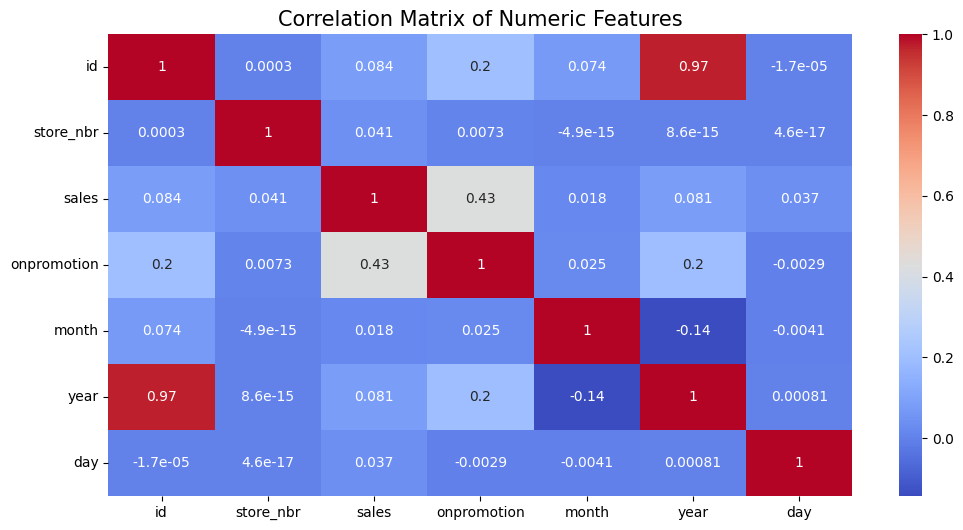

In [18]:
# Create a correlation heatmap
correlation = merged_df.drop(['family', 'month_name'], axis=1).corr()

plt.figure(figsize=(12, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features', fontsize=15)
plt.show()

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


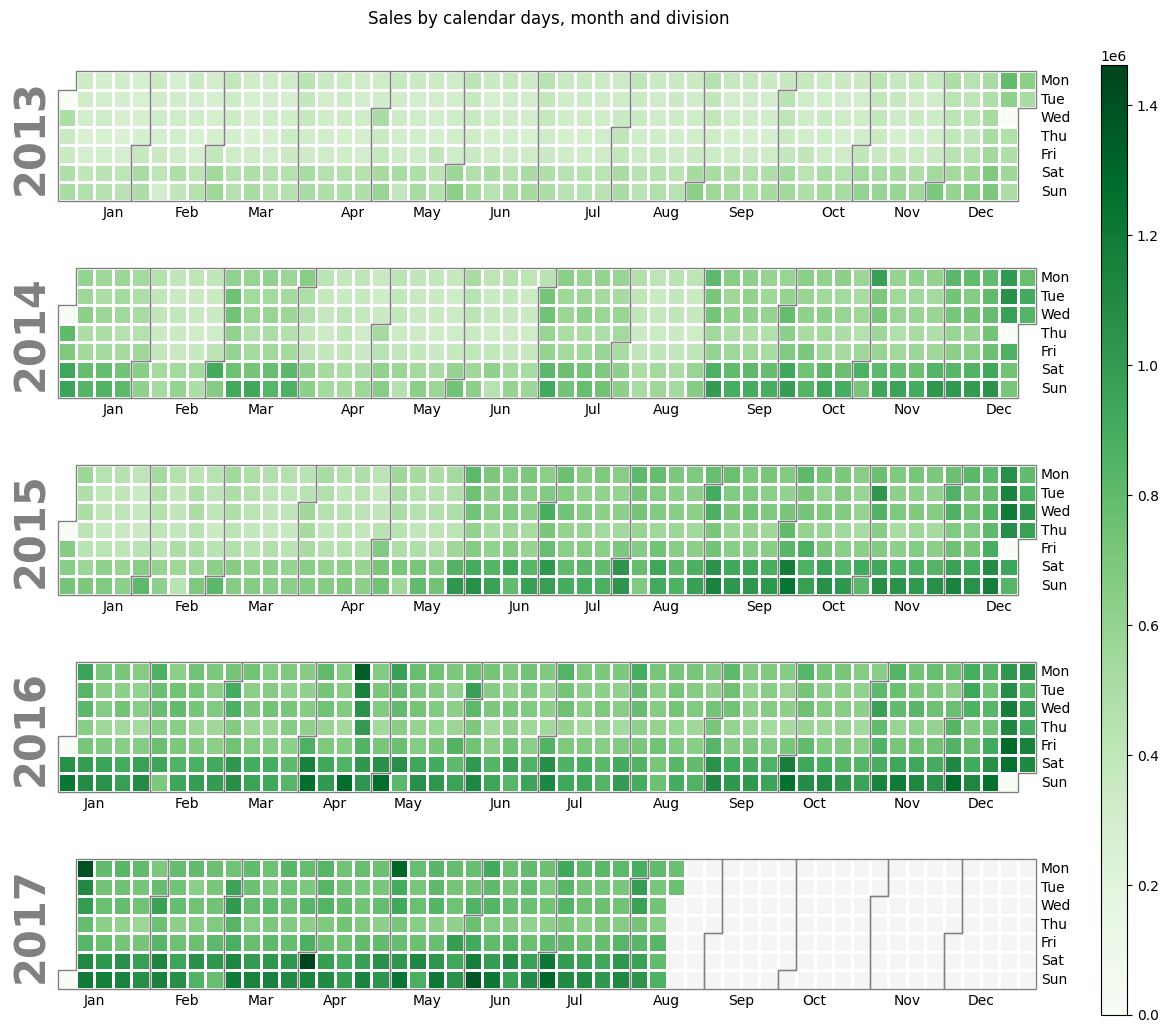

In [19]:
# Plot a calendar heatmap for daily data
calplot.calplot(merged_df['sales'], how='sum', cmap='Greens', figsize=(13, 10), suptitle='Sales by calendar days, month and division')
plt.show()


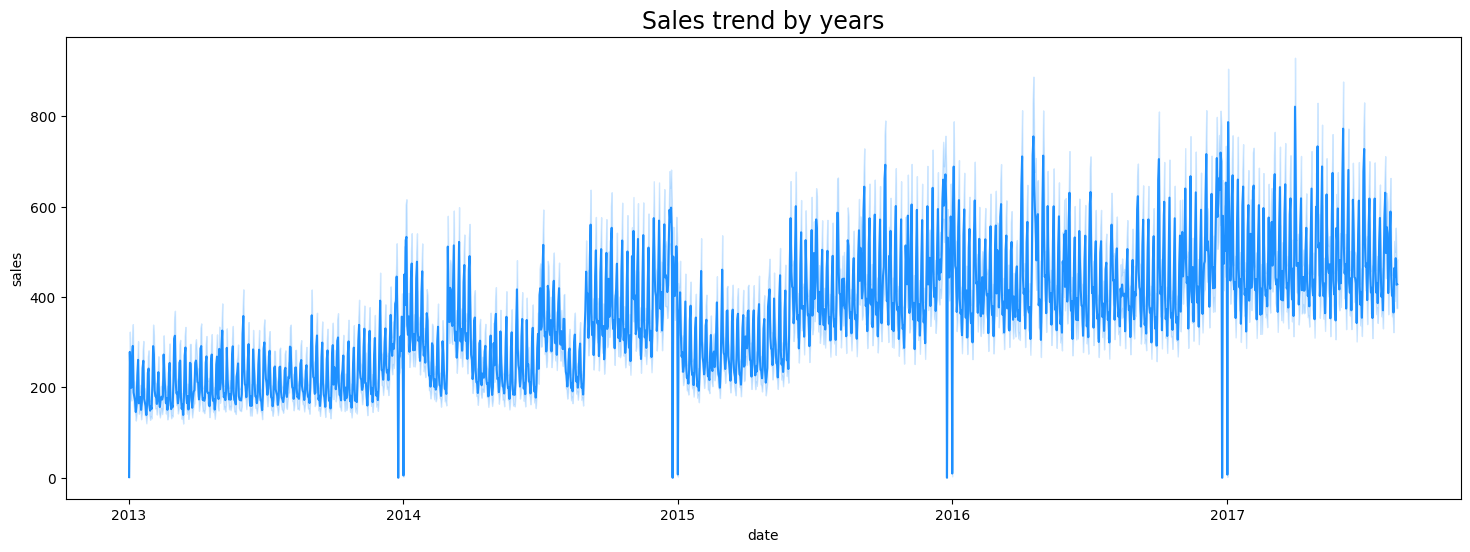

In [20]:
plt.figure(figsize=(18, 6))
sns.lineplot(data=merged_df, x=merged_df.index, y="sales", color="dodgerblue")
plt.title('Sales trend by years', fontsize=17)
plt.show()

##### Decompose

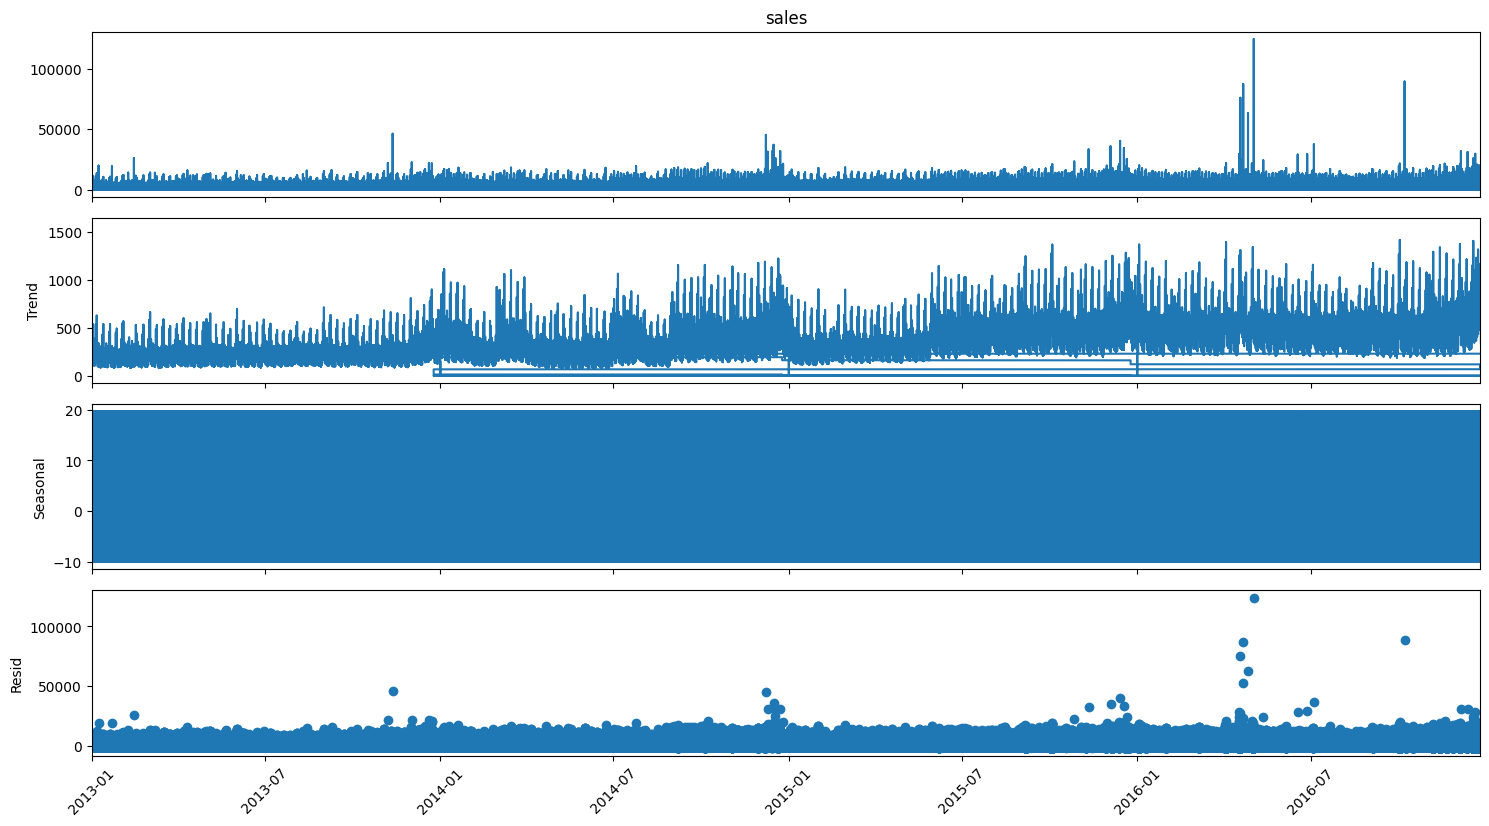

In [21]:
# Decompose the time series into trend, seasonality, and residual
result = seasonal_decompose(merged_df['sales'], model='additive', period=365)
plt.rcParams.update({'figure.figsize': (15, 8)})
result.plot()
plt.xticks(rotation=45)
plt.show()

There is a clear trend in sales growth from year to year. However, the visualizations do not show any seasonality.

In [22]:
# Extract components and create a new DataFrame
decomposition_merged_df = pd.DataFrame({
    'Trend': result.trend,
    'Seasonality': result.seasonal,
    'Residual': result.resid,
    'Observed': result.observed,
})

##### Stationary Testing

In [23]:
### Stationarity Testing
# Resample and calculate the mean only on the 'sales' column
df_downsampled = merged_df[['sales']].resample('W').mean()
df_downsampled.fillna(0, inplace=True)

In [24]:
# Use the ADF to calculate stationarity in sales
result = adfuller(df_downsampled['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

ADF Statistic: -1.4817509177560237
p-value: 0.5425188110982655
Data is not stationary


In [25]:
# Rolling mean and standard deviation
rolling_mean = merged_df['sales'].rolling(window=7).mean()
rolling_std = merged_df['sales'].rolling(window=7).std()

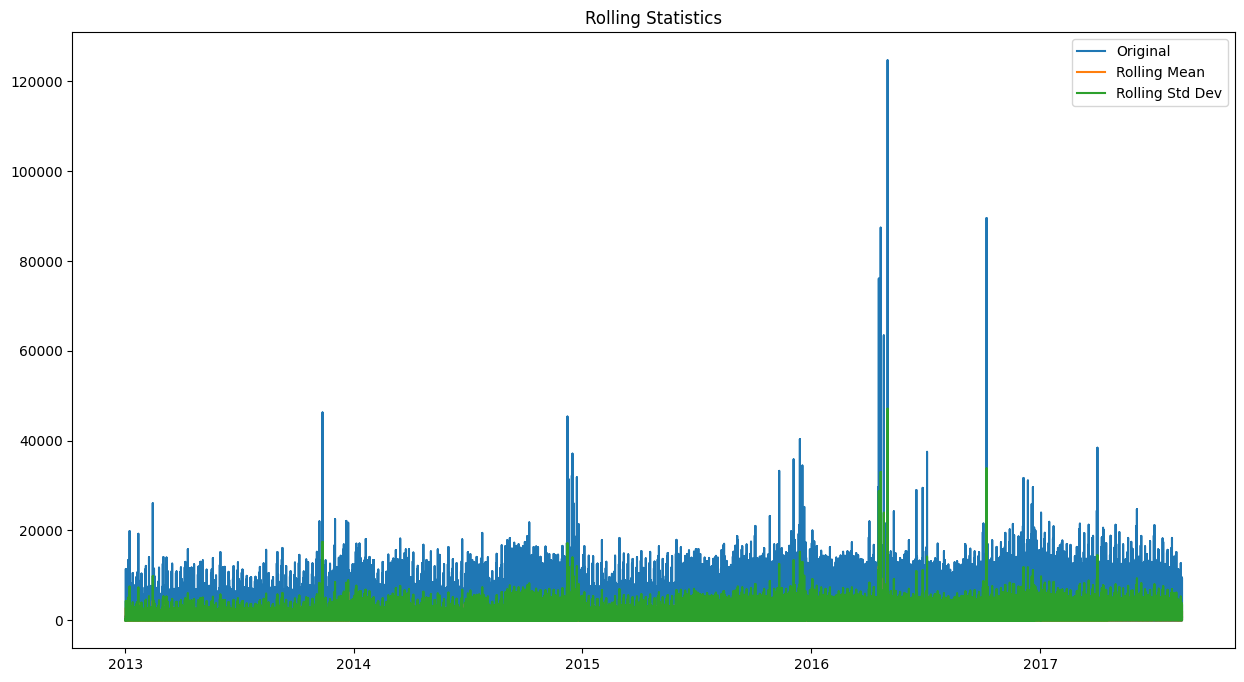

In [26]:
plt.plot(merged_df['sales'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std Dev')
plt.legend(loc='best')
plt.title('Rolling Statistics')
plt.show()

#### Key Insights
The sales and onpromotion columns are heavily skewed with a lot of outliers.

The data is not stationary, which means it does not maintain a constant mean, variance, and covariance over time.

In [27]:
# Merge datasets
merged_df_with_stores = pd.merge(left=merged_df, right=stores, left_on='store_nbr', right_on='store_nbr', suffixes=('', '_stores'))


### Analytical Questions

Q1. Check if the train dataset is complete

In [28]:
# Check for missing dates in the dataset
start_date = min(merged_df.index)
end_date = max(merged_df.index)
complete_sequence = pd.date_range(start_date, end_date, freq='D')
missing_dates = sorted(set(complete_sequence) - set(merged_df.index))

if missing_dates:
    print("Train dataset is NOT complete.")
    print("Missing dates:", ', '.join(missing_dates.strftime('%Y-%m-%d')))
else:
    print("Train dataset IS complete.")

Train dataset IS complete.


####  Q2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?


In [29]:
merged_df = merged_df[merged_df['sales'] != 0]
merged_df['year'] = merged_df.index.year

min_sales = merged_df.groupby(['year', 'date'])['sales'].min().reset_index()
max_sales = merged_df.groupby(['year', 'date'])['sales'].max().reset_index()

min_sales = min_sales[min_sales['sales'] == min_sales.groupby('year')['sales'].transform('min')]
max_sales = max_sales[max_sales['sales'] == max_sales.groupby('year')['sales'].transform('max')]


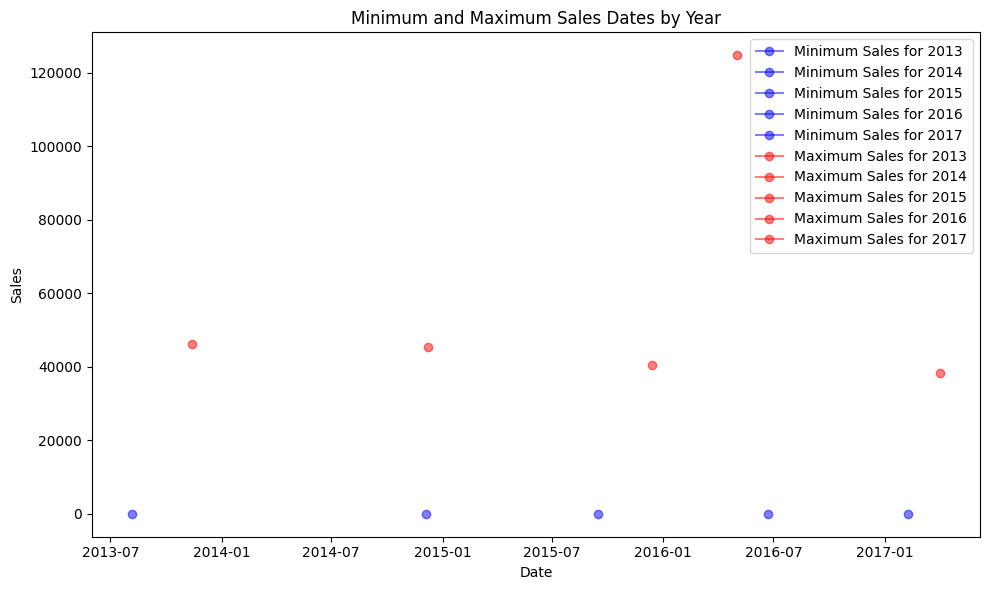

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
for year, group in min_sales.groupby('year'):
    ax.plot(group['date'], group['sales'], 'o-', color='blue', label=f'Minimum Sales for {year}', alpha=0.5)
for year, group in max_sales.groupby('year'):
    ax.plot(group['date'], group['sales'], 'o-', color='red', label=f'Maximum Sales for {year}', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Minimum and Maximum Sales Dates by Year')
ax.legend()
plt.tight_layout()
plt.show()

In [31]:
min_dates = min_sales['date'].dt.strftime('%Y-%m-%d')
max_dates = max_sales['date'].dt.strftime('%Y-%m-%d')
print("Dates with Minimum Sales:", min_dates)
print("\nDates with Maximum Sales:", max_dates)

Dates with Minimum Sales: 217     2013-08-06
702     2014-12-05
985     2015-09-15
1266    2016-06-23
1496    2017-02-09
Name: date, dtype: object

Dates with Maximum Sales: 315     2013-11-12
705     2014-12-08
1075    2015-12-14
1214    2016-05-02
1548    2017-04-02
Name: date, dtype: object


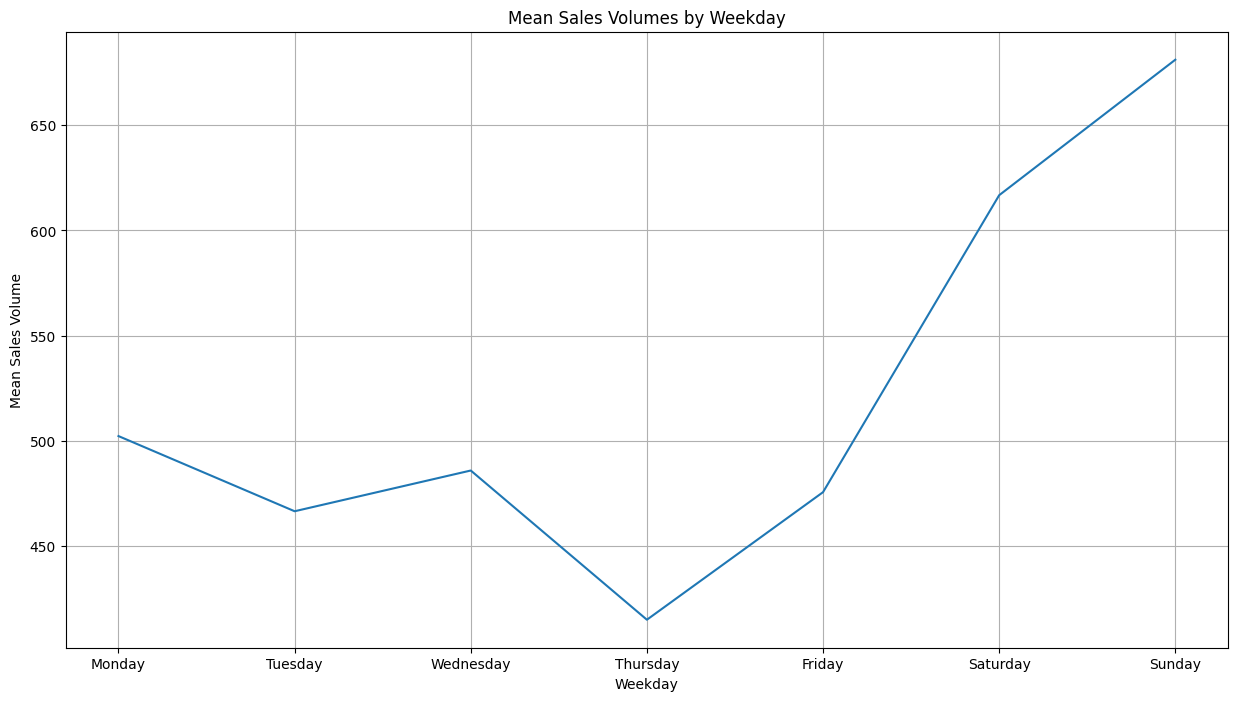

Thursdays have the lowest sales, and Saturdays and Sundays have the highest sales.


In [32]:
weekday_means = merged_df['sales'].groupby(merged_df.index.weekday).mean()
plt.plot(weekday_means.index, weekday_means.values)
plt.title('Mean Sales Volumes by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Mean Sales Volume')
plt.grid()
plt.xticks(range(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.show()
print("Thursdays have the lowest sales, and Saturdays and Sundays have the highest sales.")

Q4. Did the earthquake impact sales

In [33]:
eq_date = pd.Timestamp('2016-04-16')
before_eq_sales = merged_df[merged_df.index < eq_date]['sales'].mean()
after_eq_sales = merged_df[merged_df.index > eq_date]['sales'].mean()
rel_diff = ((after_eq_sales - before_eq_sales) / abs(before_eq_sales)) * 100
print(f"The average sales before the earthquake was: {before_eq_sales:,.2f}")
print(f"The average sales after the earthquake was: {after_eq_sales:,.2f}")
print(f"Relative difference in sales before and after the earthquake: {rel_diff:.2f} %")


The average sales before the earthquake was: 500.95
The average sales after the earthquake was: 557.52
Relative difference in sales before and after the earthquake: 11.29 %


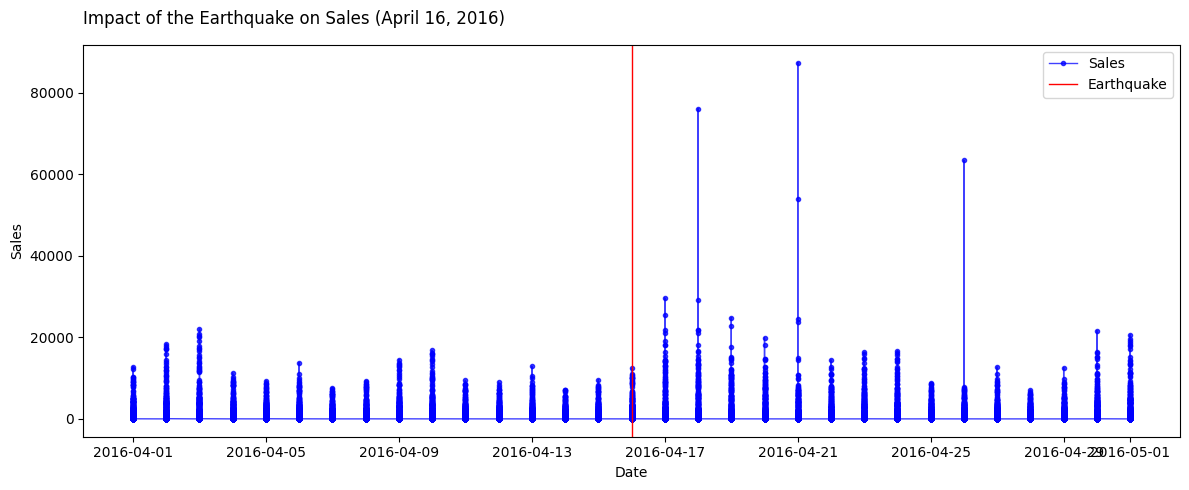

In [34]:
impact_window = merged_df.loc[eq_date - pd.Timedelta('15 days'): eq_date + pd.Timedelta('15 days')]
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(impact_window.index, impact_window['sales'], marker='.', linestyle='-', linewidth=1, color='blue', alpha=0.75, label='Sales')
ax.axvline(eq_date, color='red', linestyle='-', linewidth=1, label='Earthquake')
ax.set_title(f"Impact of the Earthquake on Sales ({eq_date.strftime('%B %d, %Y')})", loc='left', pad=15)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.tight_layout()
plt.show()

The earthquake has definitely imacted sales as shown from the graph as well as the data above it.

Q4. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

In [35]:
avg_sales_per_store = merged_df_with_stores.groupby(['cluster', 'city', 'state', 'type'])['sales'].mean().reset_index()
avg_sales_per_store_sorted = avg_sales_per_store.sort_values('sales', ascending=False)

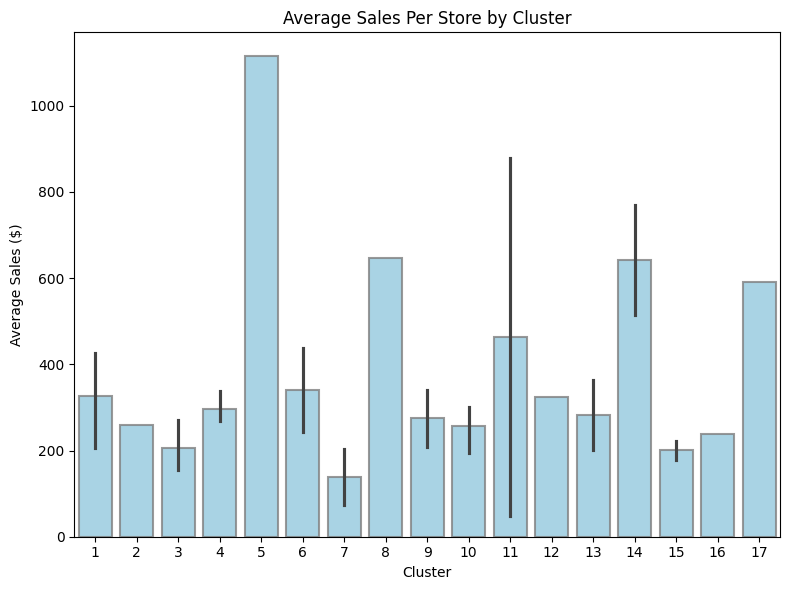

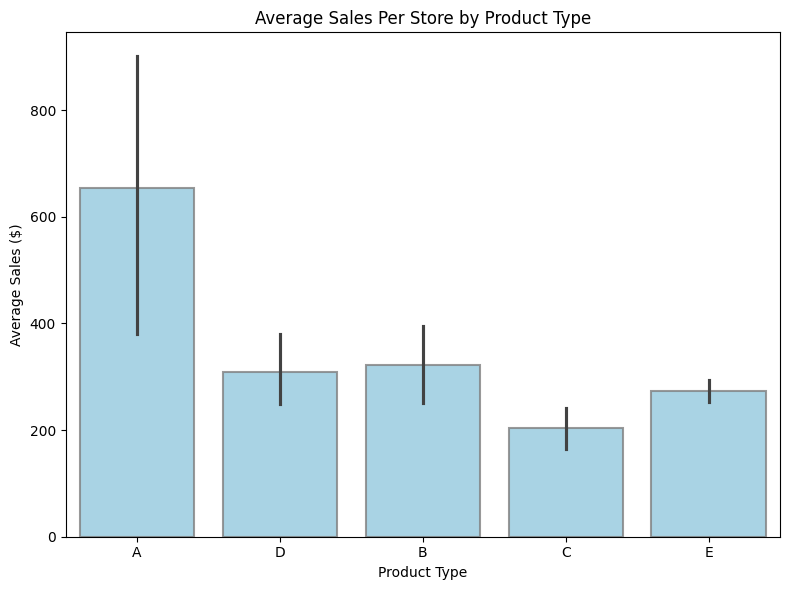

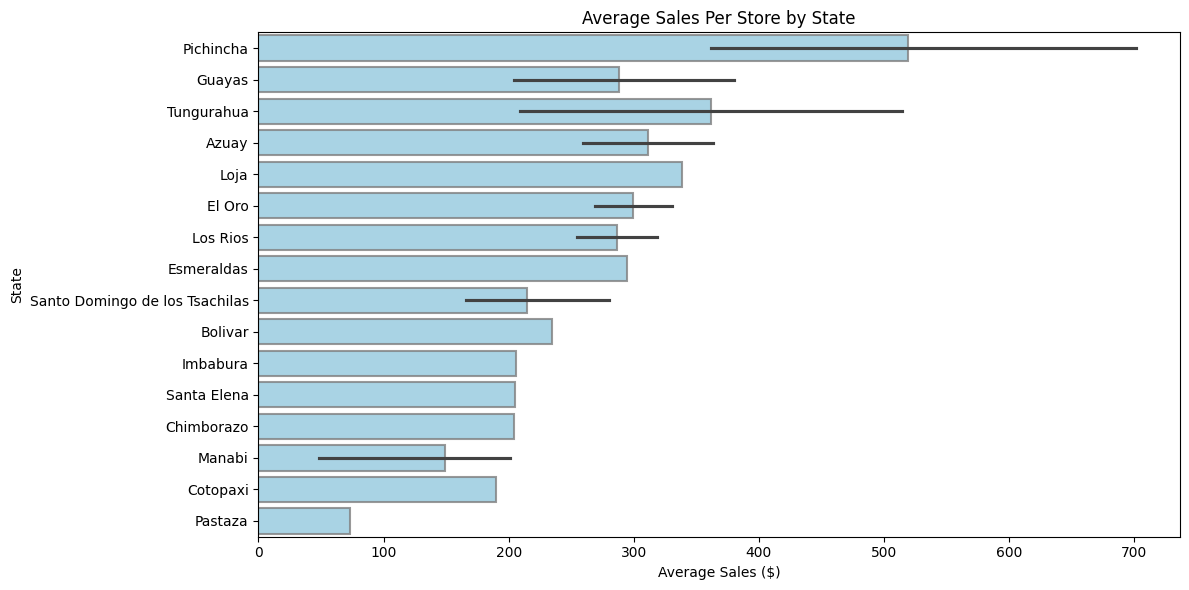

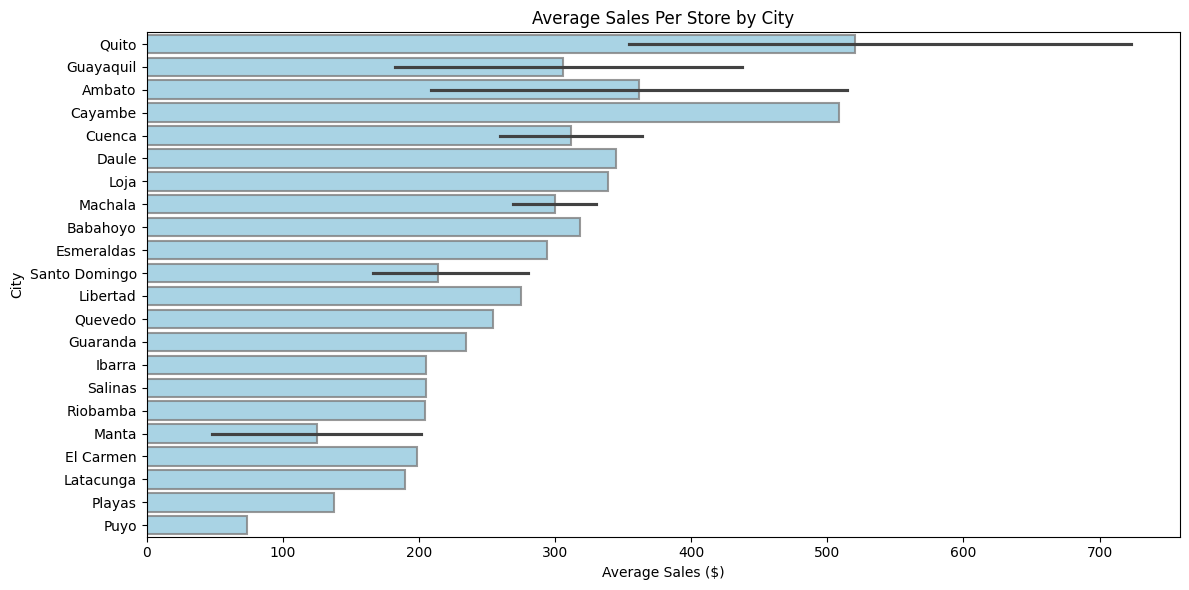

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=avg_sales_per_store_sorted['cluster'], y=avg_sales_per_store_sorted['sales'], color='skyblue', alpha=0.8, edgecolor='gray', linewidth=1.5)
ax.set_title('Average Sales Per Store by Cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Average Sales ($)')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=avg_sales_per_store_sorted['type'], y=avg_sales_per_store_sorted['sales'], color='skyblue', alpha=0.8, edgecolor='gray', linewidth=1.5)
ax.set_title('Average Sales Per Store by Product Type')
ax.set_xlabel('Product Type')
ax.set_ylabel('Average Sales ($)')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=avg_sales_per_store_sorted['sales'], y=avg_sales_per_store_sorted['state'], orient='h', color='skyblue', alpha=0.8, edgecolor='gray', linewidth=1.5)
ax.set_title('Average Sales Per Store by State')
ax.set_xlabel('Average Sales ($)')
ax.set_ylabel('State')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=avg_sales_per_store_sorted['sales'], y=avg_sales_per_store_sorted['city'], orient='h', color='skyblue', alpha=0.8, edgecolor='gray', linewidth=1.5)
ax.set_title('Average Sales Per Store by City')
ax.set_xlabel('Average Sales ($)')
ax.set_ylabel('City')
plt.tight_layout()
plt.show()


#### Feature Engineering

In [37]:
# Check if 'date' column is missing
if 'date' not in merged_df_with_stores.columns:
    print("The 'date' column is missing.")
    # Check if 'year', 'month', and 'day' columns are present
    missing_columns = [col for col in ['year', 'month', 'day'] if col not in merged_df_with_stores.columns]
    if not missing_columns:
        print("Reconstructing 'date' from 'year', 'month', and 'day' columns.")
        # Validate and clean the 'year', 'month', and 'day' columns
        try:
            # Remove any invalid date components
            merged_df_with_stores = merged_df_with_stores[(merged_df_with_stores['month'] > 0) & (merged_df_with_stores['month'] <= 12)]
            merged_df_with_stores = merged_df_with_stores[(merged_df_with_stores['day'] > 0) & (merged_df_with_stores['day'] <= 31)]
            
            # Create 'date' column from 'year', 'month', and 'day'
            merged_df_with_stores['date'] = pd.to_datetime(merged_df_with_stores[['year', 'month', 'day']])
        except Exception as e:
            print(f"Error reconstructing 'date' column: {e}")
            raise
    else:
        print(f"Cannot reconstruct 'date' column. Missing columns: {missing_columns}")
        raise KeyError(f"Missing columns for reconstruction: {missing_columns}")
else:
    # Ensure 'date' column is of datetime type
    merged_df_with_stores['date'] = pd.to_datetime(merged_df_with_stores['date'])

# Feature Engineering
try:
    merged_df_with_stores['day_of_week'] = merged_df_with_stores['date'].dt.dayofweek
    merged_df_with_stores['is_weekend'] = merged_df_with_stores['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    merged_df_with_stores['sales_lag_1'] = merged_df_with_stores['sales'].shift(1)
    window_size = 7
    merged_df_with_stores['moving_average'] = merged_df_with_stores['sales'].rolling(window=window_size).mean()
    merged_df_with_stores.dropna(inplace=True)
    print("Feature engineering completed successfully.")
except KeyError as e:
    print(f"Key error in feature engineering: {e}")
except Exception as e:
    print(f"An error occurred during feature engineering: {e}")



The 'date' column is missing.
Reconstructing 'date' from 'year', 'month', and 'day' columns.
Feature engineering completed successfully.


In [38]:
oil_df = pd.read_csv('Datasets\oil.csv', parse_dates=['date'])


In [39]:
# Merge with oil data on 'date'
merged_df2 = pd.merge(merged_df_with_stores, oil_df, on='date', how='left')

# Rename columns if there are any conflicts
merged_df2.rename(columns={'dcoilwtico_x': 'dcoilwtico'}, inplace=True)

# Fill missing oil prices with forward fill method
merged_df2['dcoilwtico'].fillna(method='ffill', inplace=True)


## **7. Feature Scaling and Engineering**

* Date Time Features: these are components of the time step itself for each observation.<br>
* Lag Features: these are values at prior time steps.<br>
* Window Features: these are a summary of values over a fixed window of prior time steps.<br>

In [40]:
#View the data
merged_df2.head()

,id,store_nbr,family,sales,onpromotion,month_name,month,year,day,city,state,type,cluster,date,day_of_week,is_weekend,sales_lag_1,moving_average,dcoilwtico
0,6.0,1,CELEBRATION,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0,NaN
1,7.0,1,CLEANING,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0,NaN
2,8.0,1,DAIRY,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0,NaN
3,9.0,1,DELI,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0,NaN
4,10.0,1,EGGS,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0,NaN


## **8. Modelling**

In [41]:
# View the data
merged_df2.head()


,id,store_nbr,family,sales,onpromotion,month_name,month,year,day,city,state,type,cluster,date,day_of_week,is_weekend,sales_lag_1,moving_average,dcoilwtico
0,6.0,1,CELEBRATION,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0,NaN
1,7.0,1,CLEANING,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0,NaN
2,8.0,1,DAIRY,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0,NaN
3,9.0,1,DELI,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0,NaN
4,10.0,1,EGGS,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0,NaN


In [42]:

# Step 1: Create a dictionary to map month names to month numbers
month_name_to_number = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Step 2: Map the month names to numbers
merged_df_with_stores['month'] = merged_df_with_stores['month_name'].map(month_name_to_number)

# Step 3: Replace invalid 'day' values (e.g., 00) with a valid day (e.g., 1)
merged_df_with_stores['day'] = merged_df_with_stores['day'].replace(0, 1)

# Step 4: Create the 'date' column
merged_df_with_stores['date'] = pd.to_datetime(
    merged_df_with_stores[['year', 'month', 'day']]
)

# Step 5: Set 'date' as the index and sort the DataFrame
time_series = merged_df_with_stores[['date', 'sales']]
time_series = time_series.set_index('date')
time_series = time_series.sort_index(ascending=True)

# Display the time series DataFrame
print(time_series)



               sales
date                
2013-01-01     0.000
2013-01-01     0.000
2013-01-01     0.000
2013-01-01    75.885
2013-01-01    31.923
...              ...
2017-08-06     1.000
2017-08-06     4.000
2017-08-06   114.000
2017-08-06  1048.000
2017-08-06     0.000

[2578548 rows x 1 columns]


Transactions per day

In [43]:
# Transactions per day
duplicate_count = time_series.index.duplicated().sum()

# Print or display the count of duplicates
print(duplicate_count)


2578212


In [44]:
### Adding the values
time_series = time_series.groupby(time_series.index).sum()
time_series = time_series.sort_index(ascending=True)
time_series


,sales
date,
2013-01-01,1.180692e+06
2013-01-02,1.681291e+06
2013-01-03,1.406442e+06
2013-01-04,1.230351e+06
2013-01-05,1.726868e+06
...,...
2017-08-02,1.698852e+06
2017-08-03,1.379455e+06
2017-08-04,1.654149e+06


### Decomposition

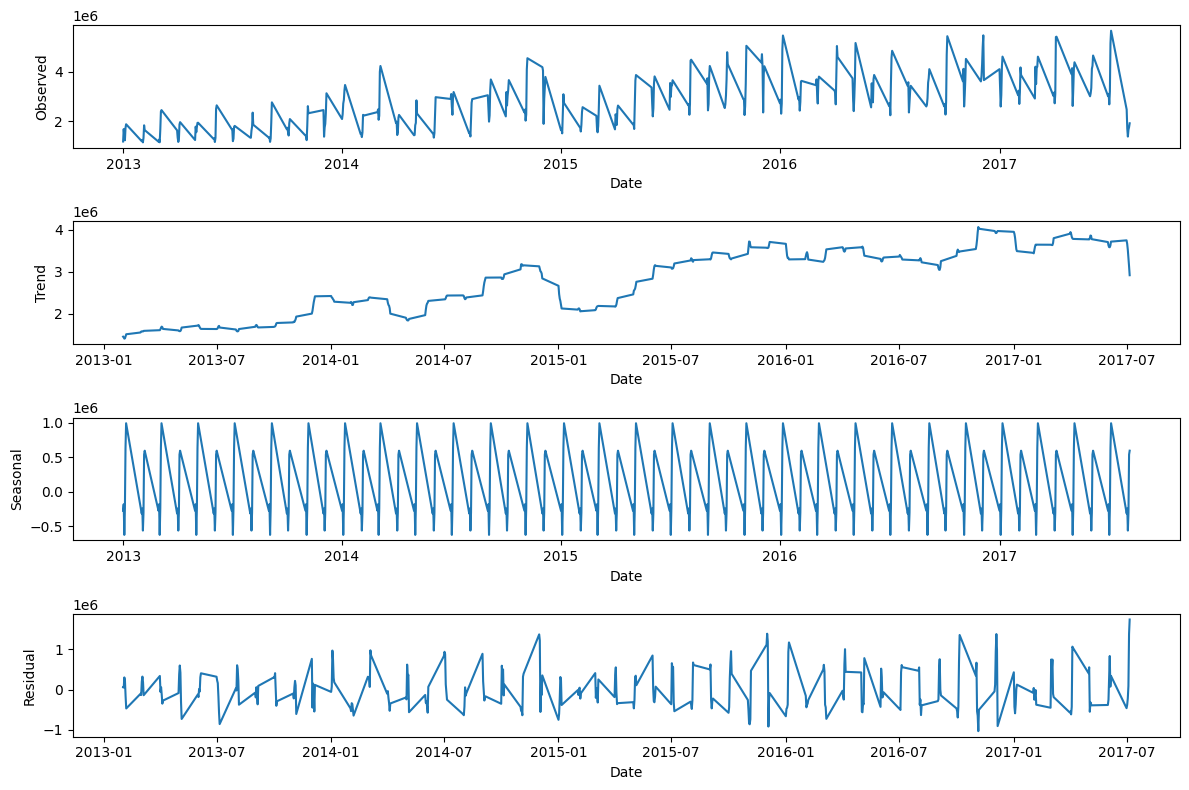

In [45]:
period = 12  # Adjust based on your data's periodicity

# Perform seasonal decomposition
result = seasonal_decompose(time_series, model='additive', period=period)

# Plot the decomposition components (trend, seasonal, residual)
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(result.observed)
plt.xlabel('Date')
plt.ylabel('Observed')
plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.xlabel('Date')
plt.ylabel('Trend')
plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

In [46]:
train_data, test_data = train_test_split(time_series, test_size=0.20, random_state=42)


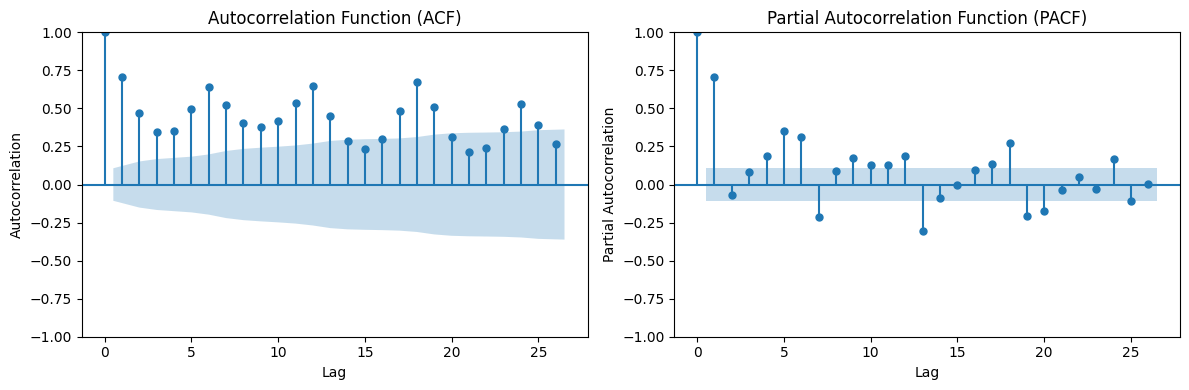

In [47]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot ACF (Autocorrelation Function)
plot_acf(time_series,ax=ax1)
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF (Partial Autocorrelation Function)
plot_pacf(time_series,ax=ax2)
ax2.set_xlabel('Lag')
ax2.set_ylabel('Partial Autocorrelation')
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

#### They show gradual delay thus model selection criteria will be based on Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC)

>## **8.1. SARIMA Model**

### Using the auto_arima function to find the most optimal sarima model

In [48]:
## Determining the Optimal sarima model for the train data
sarima_model = pm.auto_arima(time_series, 
                             m=12,
                             seasonal=True,
                             start_p=0,
                             start_q=0,
                             start_P=0,
                             start_Q=0,
                             max_order=6, 
                             test='adf',
                             error_action='warn',  
                             suppress_warnings=True,
                              stepwise=True,
                              trace=False)



##basically, we are telling autoarima to perform a grid-cv kinda search to find the best parameters

##stepwise = true means the model will systematically take a look at each p,d,q values set to choose the best pdq combo based on AIC

## we choose the max p,d,q per information from our pACF and ACF plot

##result

In [49]:
print(sarima_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  336
Model:             SARIMAX(3, 0, 2)x(1, 0, [1], 12)   Log Likelihood               -4918.873
Date:                              Sun, 19 May 2024   AIC                           9853.746
Time:                                      21:32:27   BIC                           9884.283
Sample:                                           0   HQIC                          9865.919
                                              - 336                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4903      0.076     -6.449      0.000      -0.639      -0.341
ar.L2          0.15

The optimal SARIMA model has the following orders:<br>

Autoregressive order (p): 4 <br>
Differencing order (d): 0 <br>
Moving average order (q): 0 <br>
Seasonal order: 0,0,0"

### Fitting SARIMA (4,0,0)

In [50]:
# Fit the SARIMA(1,0,0) model
order = (4, 0, 0)
seasonal_order = (0, 0, 0, 0)  # Since it's SARIMA(1,0,0), seasonal order is (0,0,0,0)

sarima_model = SARIMAX(train_data['sales'], order=order, seasonal_order=seasonal_order)
result = sarima_model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  268
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -4121.416
Date:                Sun, 19 May 2024   AIC                           8252.833
Time:                        21:32:28   BIC                           8270.787
Sample:                             0   HQIC                          8260.044
                                - 268                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2574      0.065      3.929      0.000       0.129       0.386
ar.L2          0.2042      0.065      3.131      0.002       0.076       0.332
ar.L3          0.2142      0.065      3.313      0.0

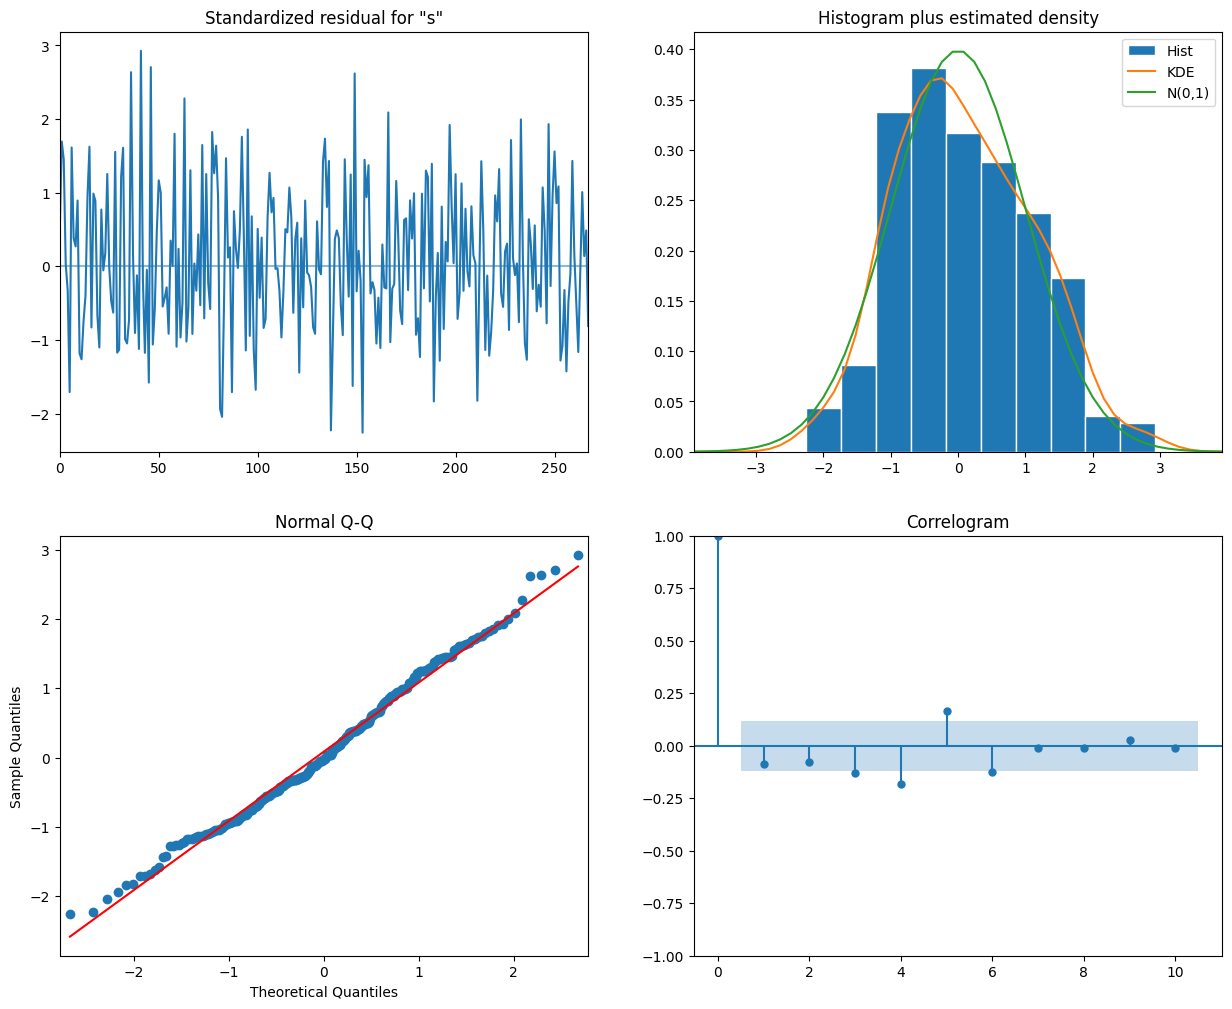

In [51]:
result.plot_diagnostics(figsize=(15, 12))
plt.show()

## 8.2. ARIMA Model

In [52]:
stepwise_fit=auto_arima(time_series["sales"],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9947.690, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10058.664, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10058.535, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10046.085, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10056.668, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9964.370, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9962.100, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=9946.125, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9954.509, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=9942.688, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=9941.019, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=9963.924, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=9915.711, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=9925.895, Time=0.07 sec
 ARIMA(5,1,2)(0,0,0)[0] inter

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  336
Model:               SARIMAX(5, 1, 1)   Log Likelihood               -4949.861
Date:                Sun, 19 May 2024   AIC                           9913.723
Time:                        21:32:31   BIC                           9940.422
Sample:                             0   HQIC                          9924.367
                                - 336                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7998      0.111     -7.205      0.000      -1.017      -0.582
ar.L2         -0.5712      0.054    -10.482      0.000      -0.678      -0.464
ar.L3         -0.5992      0.064     -9.323      0.000      -0.725      -0.473
ar.L4         -0.6192      0.060    -10.324      0.000      -0.737      -0.502
ar.L5         -0.4950      0.052     -9.596      0.000      -0.596      -0.394
ma.L1          0.4570      0.119      3.826      0.000       0.223       0.691
sigma2      4.144e+11   1.02e-13   4.04e+24      0.000    4.14e+11    4.14e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                12.17
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               2.26   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.5e+40. Standard errors may be unstable.
"""

#### Our optimal ARIMA model is order 1,1,2

In [53]:
arima_model=ARIMA(train_data,order=(1,1,2))
model=arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  268
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -4085.706
Date:                Sun, 19 May 2024   AIC                           8179.413
Time:                        21:32:31   BIC                           8193.762
Sample:                             0   HQIC                          8185.177
                                - 268                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7627      0.333     -2.292      0.022      -1.415      -0.110
ma.L1         -0.1898      0.310     -0.613      0.540      -0.797       0.417
ma.L2         -0.8059      0.304     -2.651      0.0

## 8.3. AR Model

### Find the Lags to find optimal model

In [54]:
# Create a function to fit AR models and return AIC
def fit_ar_model(order, data):
    model = sm.tsa.ARIMA(data, order=order)
    results = model.fit()
    return results.aic

# Define a range of AR model orders to consider
p_values = range(1, 11)  # Consider AR models with orders from 1 to 10

# Evaluate AIC for each AR model order
aic_values = [fit_ar_model((order, 0, 0), time_series) for order in p_values]

# Find the optimal AR model order (lowest AIC value)
optimal_order = p_values[np.argmin(aic_values)]
print("Optimal AR Model Order (based on AIC):", optimal_order)

Optimal AR Model Order (based on AIC): 10


#### The most optimal lags is 4 to find an optimal AR model

##### Fitting an AR model of lags = 10 is where ARIMA is order(10,0,0)

In [55]:
order = (4, 0, 0)  # AR order = 10, differencing order = 0, MA order = 0
model_ar= sm.tsa.ARIMA(train_data, order=order)
results = model_ar.fit()

# Print model summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  268
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -4094.097
Date:                Sun, 19 May 2024   AIC                           8200.194
Time:                        21:32:32   BIC                           8221.740
Sample:                             0   HQIC                          8208.848
                                - 268                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.75e+06    6.9e+04     39.834      0.000    2.62e+06    2.89e+06
ar.L1          0.0297      0.062      0.477      0.633      -0.092       0.152
ar.L2         -0.0153      0.062     -0.248      0.8

## 8.4. Simple Exponential Smoothing Model

In [56]:


# Fit Simple Exponential Smoothing (SES) on the training data
model_exp = SimpleExpSmoothing(train_data['sales']).fit()

# Forecast using the model on the testing set
forecast = model_exp.forecast(len(test_data))

# Ensure test_data['sales'] and forecast have the same length
test_sales = test_data['sales']

# Adjust lengths if they are inconsistent
min_length = min(len(test_sales), len(forecast))
test_sales = test_sales[:min_length]
forecast = forecast[:min_length]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_sales, forecast)
print('Mean Squared Error:', mse)
print(model_exp.summary())


Mean Squared Error: 1204215401169.0945
                        SimpleExpSmoothing Model Results                       
Dep. Variable:                  sales   No. Observations:                   268
Model:             SimpleExpSmoothing   SSE                 318099126734882.250
Optimized:                       True   AIC                            7455.042
Trend:                           None   BIC                            7462.224
Seasonal:                        None   AICC                           7455.195
Seasonal Periods:                None   Date:                  Sun, 19 May 2024
Box-Cox:                        False   Time:                          21:32:32
Box-Cox Coeff.:                  None                                          
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.0855814                alpha                 True
init

In [57]:
# Fit Simple Exponential Smoothing (SES) on the training data
model_exp = SimpleExpSmoothing(train_data['sales']).fit()

# Forecast using the model on the testing set
forecast = model_exp.forecast(len(test_data))

# Ensure test_data['sales'] and forecast have the same length
test_sales = test_data['sales']

# Handle length mismatch by dropping excess values from the longer series
if len(test_sales) != len(forecast):
    min_length = min(len(test_sales), len(forecast))
    test_sales = test_sales[:min_length]
    forecast = forecast[:min_length]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_sales, forecast)
print('Mean Squared Error:', mse)
print(model_exp.summary())


Mean Squared Error: 1204215401169.0945
                        SimpleExpSmoothing Model Results                       
Dep. Variable:                  sales   No. Observations:                   268
Model:             SimpleExpSmoothing   SSE                 318099126734882.250
Optimized:                       True   AIC                            7455.042
Trend:                           None   BIC                            7462.224
Seasonal:                        None   AICC                           7455.195
Seasonal Periods:                None   Date:                  Sun, 19 May 2024
Box-Cox:                        False   Time:                          21:32:32
Box-Cox Coeff.:                  None                                          
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.0855814                alpha                 True
init

In [58]:
# Fit Simple Exponential Smoothing (SES) on the training data
model_exp = SimpleExpSmoothing(train_data['sales'])
results_exp = model_exp.fit()

# Forecast using the model on the testing set
forecast = results_exp.forecast(len(test_data))

# Ensure that the forecast and test data have the same length
forecast = forecast[:len(test_data)]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_data['sales'], forecast)
print('Mean Squared Error:', mse)
print(results_exp.summary())

Mean Squared Error: 1204215401169.0945
                        SimpleExpSmoothing Model Results                       
Dep. Variable:                  sales   No. Observations:                   268
Model:             SimpleExpSmoothing   SSE                 318099126734882.250
Optimized:                       True   AIC                            7455.042
Trend:                           None   BIC                            7462.224
Seasonal:                        None   AICC                           7455.195
Seasonal Periods:                None   Date:                  Sun, 19 May 2024
Box-Cox:                        False   Time:                          21:32:32
Box-Cox Coeff.:                  None                                          
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.0855814                alpha                 True
init

#### Based on the output, the Mean Squared Error (MSE) is quite large (1398902935600.7703), which indicates that the Simple Exponential Smoothing (SES) model is not providing a good forecast for the given data.

## 8.5. Double Exponential Smoothing

In [59]:
# Adding a small constant value to make sales strictly positive
constant_value = 0.001  # or any small positive value you choose
train_data['sales_positive'] = train_data['sales'] + constant_value

# Exponential smoothing with a multiplicative trend
model = ExponentialSmoothing(np.asarray(train_data['sales_positive']), trend='mul', seasonal=None)
model_fit = model.fit()

# Make predictions
#forecast_double = model_fit.forecast(steps=36)

# Print the forecasted values
#print("Forecasted values:")
#print(forecast)
print(model_fit.summary())


                        ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                   268
Model:             ExponentialSmoothing   SSE                 334984113672688.625
Optimized:                         True   AIC                            7472.903
Trend:                   Multiplicative   BIC                            7487.267
Seasonal:                          None   AICC                           7473.225
Seasonal Periods:                  None   Date:                  Sun, 19 May 2024
Box-Cox:                          False   Time:                          21:32:32
Box-Cox Coeff.:                    None                                          
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.1464286                alpha                 True
smoothing_trend          

## 8.5. Tripple Exponential Smoothing

In [60]:
train_data=train_data.drop(columns='sales_positive')

In [61]:
# Define the seasonal period (e.g., 12 for monthly data if there's yearly seasonality)
seasonal_period = 12

# Create a Triple Exponential Smoothing model
model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=seasonal_period)

# Fit the model
fit_model = model.fit()

# Forecast future values
# Forecast 10 steps ahead (you can adjust the steps as needed)
forecast = fit_model.forecast(steps=36)

# Print the forecasted values
#print("Forecasted values:")
#print(forecast)
print(fit_model.summary())

                        ExponentialSmoothing Model Results                       
Dep. Variable:                    sales   No. Observations:                   268
Model:             ExponentialSmoothing   SSE                 322878424481853.062
Optimized:                         True   AIC                            7487.039
Trend:                         Additive   BIC                            7544.495
Seasonal:                      Additive   AICC                           7489.786
Seasonal Periods:                    12   Date:                  Sun, 19 May 2024
Box-Cox:                          False   Time:                          21:32:33
Box-Cox Coeff.:                    None                                          
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0403571                alpha                 True
smoothing_trend 

#### Lower values of AIC and BIC generally indicate a better model fit. However, without seeing the actual values, it's difficult to assess whether the fit is good or not.Without seeing the forecasted values or the actual values in the test set, it's difficult to assess the forecast quality. Therefore, we will further test with Tripple Exponential Smoothing since it can handle both trend and seasonal components

## 8.5 Tripple Exponential Smoothing

In [62]:
# Define the seasonal period (e.g., 12 for monthly data if there's yearly seasonality)
seasonal_period = 12

# Create a Triple Exponential Smoothing model
model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=seasonal_period)

# Fit the model
fit_model = model.fit()

# Forecast future values
# Forecast 10 steps ahead (you can adjust the steps as needed)
forecast = fit_model.forecast(steps=36)

# Print the forecasted values
#print("Forecasted values:")
#print(forecast)
print(fit_model.summary())

                        ExponentialSmoothing Model Results                       
Dep. Variable:                    sales   No. Observations:                   268
Model:             ExponentialSmoothing   SSE                 322878424481853.062
Optimized:                         True   AIC                            7487.039
Trend:                         Additive   BIC                            7544.495
Seasonal:                      Additive   AICC                           7489.786
Seasonal Periods:                    12   Date:                  Sun, 19 May 2024
Box-Cox:                          False   Time:                          21:32:33
Box-Cox Coeff.:                    None                                          
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0403571                alpha                 True
smoothing_trend 

# Model Selection

### The best model is selected using AIC. The optimal oer best model has the lowest AIC. This is the double exponential model.

In [63]:
# Make predictions
forecast_double = model_fit.forecast(len(test_data))
forecast_double

array([2406025.8117954 , 2395742.3391083 , 2385502.81848937,
       2375307.06208532, 2365154.88284572, 2355046.09451965,
       2344980.5116522 , 2334957.94958111, 2324978.22443339,
       2315041.15312191, 2305146.55334209, 2295294.2435685 ,
       2285484.04305158, 2275715.7718143 , 2265989.25064884,
       2256304.30111336, 2246660.74552865, 2237058.40697494,
       2227497.10928861, 2217976.67705897, 2208496.93562505,
       2199057.71107238, 2189658.83022983, 2180300.12066639,
       2170981.41068804, 2161702.52933458, 2152463.30637651,
       2143263.5723119 , 2134103.15836327, 2124981.89647452,
       2115899.61930781, 2106856.16024053, 2097851.3533622 ,
       2088885.03347148, 2079957.03607308, 2071067.19737478,
       2062215.35428443, 2053401.34440692, 2044625.00604124,
       2035886.17817751, 2027184.70049398, 2018520.41335415,
       2009893.1578038 , 2001302.77556811, 1992749.10904871,
       1984232.00132082, 1975751.29613037, 1967306.83789112,
       1958898.47168182,

### Multivariate Modeling

In [64]:
merged_df_with_stores.head()

,id,store_nbr,family,sales,onpromotion,month_name,month,year,day,city,state,type,cluster,date,day_of_week,is_weekend,sales_lag_1,moving_average
6,6.0,1,CELEBRATION,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0
7,7.0,1,CLEANING,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0
8,8.0,1,DAIRY,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0
9,9.0,1,DELI,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0
10,10.0,1,EGGS,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0


### Feature Engineering

In [65]:
# Create day of week as a column
merged_df_with_stores['day_of_week'] = merged_df_with_stores['date'].dt.dayofweek

# Create a binary 'is_weekend' column (1 for weekends, 0 for weekdays)
merged_df_with_stores['is_weekend'] = merged_df_with_stores['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Create a lagged 'sales' column (e.g., lag 1)
merged_df_with_stores['sales_lag_1'] = merged_df_with_stores['sales'].shift(1)

# Create a rolling mean (moving average) of 'sales' with a window size of your choice
window_size = 7  # You can adjust this as needed
merged_df_with_stores['moving_average'] = merged_df_with_stores['sales'].rolling(window=window_size).mean()

# Drop rows with NaN values resulting from lag and rolling mean calculations
merged_df_with_stores = merged_df_with_stores.dropna()

# Display the updated DataFrame
merged_df_with_stores.head()

,id,store_nbr,family,sales,onpromotion,month_name,month,year,day,city,state,type,cluster,date,day_of_week,is_weekend,sales_lag_1,moving_average
12,12.0,1,GROCERY I,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0
13,13.0,1,GROCERY II,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0
14,14.0,1,HARDWARE,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0
15,15.0,1,HOME AND KITCHEN I,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0
16,16.0,1,HOME AND KITCHEN II,0.0,0.0,January,1,2013,1,Quito,Pichincha,D,13,2013-01-01,1,0,0.0,0.0


In [66]:
# Select only numerical columns for correlation
numerical_columns = ['id', 'store_nbr', 'sales', 'onpromotion', 'month', 'year',
                     'day', 'cluster', 'day_of_week', 'is_weekend', 'sales_lag_1', 'moving_average']

# Create a DataFrame with only numerical columns
numerical_df = merged_df2[numerical_columns]

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Now you have the correlation matrix for numerical columns
numerical_df.corr()


,id,store_nbr,sales,onpromotion,month,year,day,cluster,day_of_week,is_weekend,sales_lag_1,moving_average
id,1.000000,0.000293,0.083884,0.203172,0.077496,0.971359,0.000423,-0.000040,0.006969,0.008848,0.083884,0.203539
store_nbr,0.000293,1.000000,0.042136,0.006880,-0.000006,-0.000005,-0.000006,-0.059280,-0.000004,-0.000002,0.042197,0.105146
sales,0.083884,0.042136,1.000000,0.425193,0.018018,0.081298,0.046413,0.038763,0.000845,0.000702,-0.023201,0.469844
onpromotion,0.203172,0.006880,0.425193,1.000000,0.025924,0.197649,-0.025270,0.005794,0.001935,0.002524,-0.011747,0.210247
month,0.077496,-0.000006,0.018018,0.025924,1.000000,-0.141293,-0.003634,0.000003,-0.004644,-0.005910,0.018018,0.043715
year,0.971359,-0.000005,0.081298,0.197649,-0.141293,1.000000,0.002429,0.000003,0.011043,0.012617,0.081298,0.197263
day,0.000423,-0.000006,0.046413,-0.025270,-0.003634,0.002429,1.000000,0.000003,0.023141,0.001077,0.046410,0.112412
cluster,-0.000040,-0.059280,0.038763,0.005794,0.000003,0.000003,0.000003,1.000000,0.000002,0.000001,0.038689,0.089516
day_of_week,0.006969,-0.000004,0.000845,0.001935,-0.004644,0.011043,0.023141,0.000002,1.000000,0.789195,0.000845,0.002044
is_weekend,0.008848,-0.000002,0.000702,0.002524,-0.005910,0.012617,0.001077,0.000001,0.789195,1.000000,0.000702,0.001690


In [67]:
#Handling the inconsistent/repetitive values 
merged_df2.replace({"family": {"POULTRY" : "MEATS",
                            "DAIRY": "PRODUCE",
                            "EGGS" : "PRODUCE" ,
                            "HOME APPLIANCES" :   "PLAYERS AND ELECTRONICS",
                            "CLEANING" :"HOME CARE",
                            "LINGERIE" :    "LADIESWEAR",
                            "DELI" : "PREPARED FOODS",
                            "GROCERY I" : "GROCERY",
                            "GROCERY II" : "GROCERY",
                            "HOME AND KITCHEN I"  :    "HOME AND KITCHEN",
                            "HOME AND KITCHEN II" : "HOME AND KITCHEN",
                            "BEAUTY" :"PERSONAL CARE"}},inplace =True)

### Spilitting

In [68]:
# Splitting
train_data = merged_df2[:int(len(merged_df2)*0.8)]
test_data = merged_df2[int(len(merged_df2)*0.8):]

In [69]:
# Training set
X_train = train_data.drop(columns=['sales'])
y_train = train_data['sales']

In [70]:
# Testing set
X_test = test_data.drop(columns=['sales'])
y_test = test_data['sales']

### Preprocessing

In [81]:
def preprocess_data(df: pd.DataFrame):
    # Separate datetime columns
    datetime_col = df.select_dtypes(include=['datetime', 'datetime64']).columns

    # Separate Categorical and Numerical Columns, excluding datetime columns
    cat_col = df.select_dtypes(include=['object']).columns.difference(datetime_col)
    num_col = df.select_dtypes(include=['number']).columns.difference(datetime_col)

    # Define the preprocessing steps using ColumnTransformer and Pipeline
    numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
    categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', categories='auto'))])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_col),
            ('cat', categorical_transformer, cat_col)
        ], remainder='drop')  # Do not passthrough datetime columns

    # Fit and transform the data
    preprocessed = preprocessor.fit_transform(df)

    # Get the feature names
    feature_names = preprocessor.get_feature_names_out()

    # Select only the desired features
    desired_features = [feature for feature in feature_names if 'feature_name' in feature]
    preprocessed = preprocessed[:, :len(desired_features)]

    # Create a DataFrame with column names
    preprocessed_df = pd.DataFrame(preprocessed, columns=desired_features)

    # Reattach the datetime columns
    if not datetime_col.empty:
        preprocessed_df = pd.concat([df[datetime_col], preprocessed_df], axis=1)

    # Return the preprocessed data and the preprocessor
    return preprocessed_df, preprocessor


# Preprocess the training and testing data
X_train_processed, X_train_preprocessor = preprocess_data(X_train)
X_test_processed, X_test_preprocessor = preprocess_data(X_test)


ValueError: Shape of passed values is (2062838, 1), indices imply (2062838, 0)

In [83]:
X_train_processed.head()

NameError: name 'X_train_processed' is not defined